In [277]:
!pip install backtrader
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [278]:
import backtrader as bt 
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
import datetime
import yfinance as yf
from matplotlib import pyplot as plt

In [279]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

class BB_RSI(bt.Strategy):

    params = (('BB_MA', 20), ('BB_SD', 2))

    def __init__(self):
        self.order = None
        self.stopprice = None
        self.closepos = None
        self.bb = bt.indicators.BollingerBands(self.data, period=self.params.BB_MA, devfactor=self.params.BB_SD)
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=14)


    def log(self, txt, doprint=True):
        date = self.data.datetime.date(0)
        time = self.data.datetime.time(0)
        if doprint:
            print(str(date) + '--' + txt)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        elif order.status == order.Completed:
            if order.isbuy():
                self.log('BUY   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
            if order.issell():
                self.log('SELL   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
        elif order.status in [order.Rejected, order.Margin]:
            self.log('Order Rejected/Margin')

        self.order = None
    

    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('CLOSE   Gross P/L: {}, Net P/L: {}'.format(trade.pnl, trade.pnlcomm))


    def next(self):
        if self.order:
            return
        
        if self.position.size == 0:
                if (self.data.close[-1] > self.bb.lines.top[-1]) and (self.data.close[0] <= self.bb.lines.top[0] and self.rsi > 60 ):
                    self.order = self.sell()
                    self.stopprice = self.bb.lines.top[0]
                    self.closepos = self.buy(exectype=bt.Order.Stop, price=self.stopprice)

                elif (self.data.close[-1] < self.bb.lines.bot[-1]) and (self.data.close[0] >= self.bb.lines.bot[0] and self.rsi < 40):
                    self.order = self.buy()
                    self.stopprice = self.bb.lines.bot[0]
                    self.closepos = self.sell(exectype=bt.Order.Stop, price=self.stopprice)

        elif self.position.size > 0:
            if (self.data.close[-1] < self.bb.lines.mid[-1]) and (self.data.close[0] >= self.bb.lines.mid[0] and self.rsi > 50):
                self.closepos = self.close()
        elif self.position.size < 0:
            if (self.data.close[-1] > self.bb.lines.mid[-1]) and (self.data.close[0] <= self.bb.lines.mid[0] and self.rsi < 50):
                self.closepos = self.close()

In [280]:
if __name__ == '__main__':

    cerebro = bt.Cerebro()

    datapath = 'DHAMPURSUG.NS.csv'
    feed = bt.feeds.PandasData(dataname=yf.download('DHAMPURSUG.NS', '2017-01-01', '2022-10-12'))
    cerebro.adddata(feed)

    cerebro.addstrategy(BB_RSI)
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=.00001)

    cerebro.addsizer(bt.sizers.PercentSizer, percents=90)  

[*********************100%***********************]  1 of 1 completed


In [281]:
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='sr')  
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='dd')  
    cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='ar')
    cerebro.addanalyzer(btanalyzers.Returns, _name='r') 
    cerebro.addanalyzer(btanalyzers.SQN, _name='sqn')    
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='ta') 
    cerebro.addanalyzer(btanalyzers.PyFolio, _name='pf')

In [282]:
    bb = cerebro.run()
    bb1 = bb[0]
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 

2017-02-08--SELL   price: 199.25, value: -90000.0, commission: 0.9
2017-02-08--BUY   price: 201.39129201686373, value: -90000.0, commission: 0.909672084392358
2017-02-08--CLOSE   Gross P/L: -967.2084392357999, Net P/L: -969.0181113201922
2017-03-10--SELL   price: 226.0, value: -89484.23442909397, commission: 0.8948423442909397
2017-03-14--BUY   price: 230.13819527544413, value: -89484.23442909397, commission: 0.9112274432352411
2017-03-14--CLOSE   Gross P/L: -1638.509894430141, Net P/L: -1640.3159642176672
2017-04-27--SELL   price: 239.60000610351562, value: -88037.40711073186, commission: 0.8803740711073187
2017-05-19--BUY   price: 231.5, value: -88037.40711073186, commission: 0.8506118208247985
2017-05-19--CLOSE   Gross P/L: 2976.2250282520117, Net P/L: 2974.4940423600797
2017-05-26--BUY   price: 211.75, value: 91276.97486099701, commission: 0.9127697486099702
2017-05-26--SELL   price: 207.148979490183, value: 91276.97486099701, commission: 0.8929365852848462
2017-05-26--CLOSE   Gros

In [283]:
print('Sharpe Ratio:', bb1.analyzers.sr.get_analysis())

Sharpe Ratio: OrderedDict([('sharperatio', 1.2070940920267232)])


In [284]:
print('Drawdown:', bb1.analyzers.dd.get_analysis())

Drawdown: AutoOrderedDict([('len', 50), ('drawdown', 6.495757953526189), ('moneydown', 45055.37143139925), ('max', AutoOrderedDict([('len', 238), ('drawdown', 28.20624772111434), ('moneydown', 89056.31011641794)]))])


In [285]:
print('Annual Return:', bb1.analyzers.ar.get_analysis())
print('Returns:', bb1.analyzers.r.get_analysis())

Annual Return: OrderedDict([(2017, 0.15961249187212712), (2018, -0.039717745349334366), (2019, 0.3450785684111637), (2020, 0.3024366962551106), (2021, 0.7509710388639088), (2022, 0.8986854670586624)])
Returns: OrderedDict([('rtot', 1.869579487050185), ('ravg', 0.0013092293326681967), ('rnorm', 0.3908649110975901), ('rnorm100', 39.08649110975901)])


In [286]:
print('SQN:', bb1.analyzers.sqn.get_analysis())

SQN: AutoOrderedDict([('sqn', 2.040668397141977), ('trades', 64)])


In [287]:
print('Trade Analyzer:', bb1.analyzers.ta.get_analysis())

Trade Analyzer: AutoOrderedDict([('total', AutoOrderedDict([('total', 64), ('open', 0), ('closed', 64)])), ('streak', AutoOrderedDict([('won', AutoOrderedDict([('current', 0), ('longest', 2)])), ('lost', AutoOrderedDict([('current', 3), ('longest', 7)]))])), ('pnl', AutoOrderedDict([('gross', AutoOrderedDict([('total', 548786.1639584871), ('average', 8574.783811851361)])), ('net', AutoOrderedDict([('total', 548556.8560214599), ('average', 8571.200875335311)]))])), ('won', AutoOrderedDict([('total', 17), ('pnl', AutoOrderedDict([('total', 670435.6881001928), ('average', 39437.3934176584), ('max', 170808.48167353356)]))])), ('lost', AutoOrderedDict([('total', 47), ('pnl', AutoOrderedDict([('total', -121878.83207873291), ('average', -2593.1666399730407), ('max', -10617.905985114727)]))])), ('long', AutoOrderedDict([('total', 29), ('pnl', AutoOrderedDict([('total', 350168.9549908252), ('average', 12074.791551407765), ('won', AutoOrderedDict([('total', 419066.84074859635), ('average', 46562

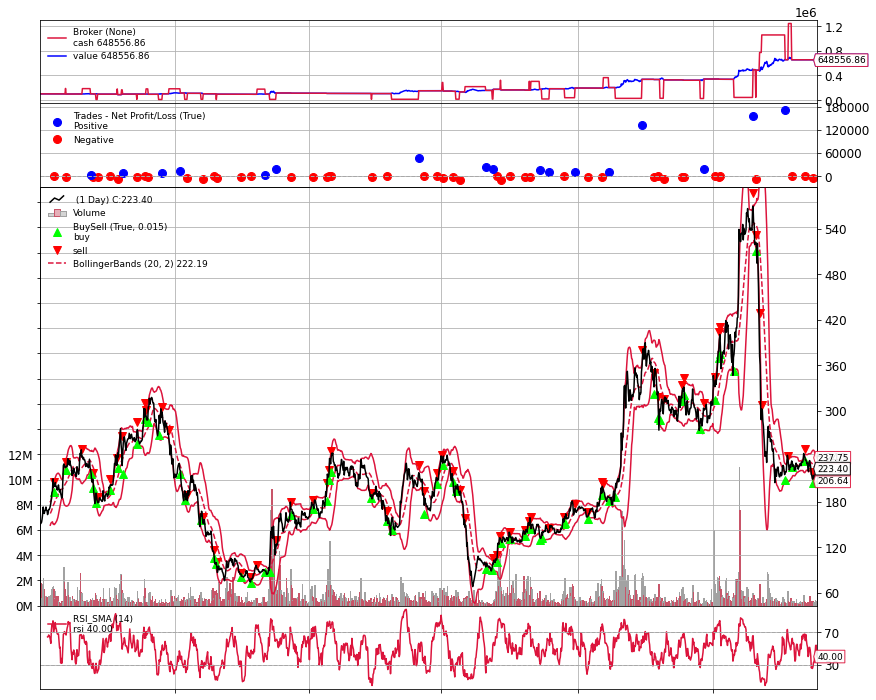

[[<Figure size 864x720 with 5 Axes>]]

In [288]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot = False)